In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import string

In [2]:
import nltk
nltk.download('punkt')
#from nltk.tokenize import sent_tokenize
import nltk.data
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /home/joseph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
try:
    total_df = pd.read_pickle('total_df.p')
except:
    df_1 = pd.read_csv('articles1.csv')
    df_2 = pd.read_csv('articles2.csv')
    df_3 = pd.read_csv('articles3.csv')
    #print(df_1.head(1))
    print(df_1.shape)

    #print(df_1.publication.unique())
    #print(df_2.publication.unique())
    #print(df_3.publication.unique())
    #merge dataframes
    total_df = pd.concat([df_1, df_2, df_3])
    df_1 = 0
    df_2 = 0
    df_3 = 0
    total_df['sentence_count'] = 0
    total_df['word_count'] = 0
    total_df.to_pickle('total_df.p')
publication_names = total_df.publication.unique()

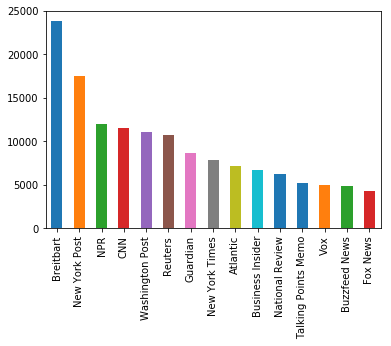

In [4]:
total_df.publication.value_counts().plot(kind='bar')

In [7]:
print(list(total_df))
print(total_df.loc[total_df['publication'] == 'New York Times']['title'])

['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count']
0       House Republicans Fret About Winning Their Hea...
1       Rift Between Officers and Residents as Killing...
2       Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...
3       Among Deaths in 2016, a Heavy Toll in Pop Musi...
4       Kim Jong-un Says North Korea Is Preparing to T...
5       Sick With a Cold, Queen Elizabeth Misses New Y...
6       Taiwan’s President Accuses China of Renewed In...
7       After ‘The Biggest Loser,’ Their Bodies Fought...
8       First, a Mixtape. Then a Romance. - The New Yo...
9       Calling on Angels While Enduring the Trials of...
10      Weak Federal Powers Could Limit Trump’s Climat...
11      Can Carbon Capture Technology Prosper Under Tr...
12      Mar-a-Lago, the Future Winter White House and ...
13      How to form healthy habits in your 20s - The N...
14      Turning Your Vacation Photos Into Works of Art...


In [4]:
#get content column into list
article_list = total_df['content'].tolist()
print(article_list[:10])

['WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been

In [5]:
word_count_list = [len(text.split()) for text in article_list[:10000]]
print(word_count_list[:100])

[884, 4770, 2389, 2119, 694, 159, 571, 3194, 1610, 818, 1183, 1809, 1322, 665, 1802, 1368, 1597, 1554, 557, 292, 1120, 773, 1204, 1999, 1320, 949, 1077, 1815, 869, 2843, 1101, 1170, 798, 410, 523, 745, 1386, 1009, 660, 1305, 1021, 1271, 1337, 1551, 574, 1340, 847, 395, 1328, 1060, 1652, 1280, 358, 847, 1264, 1972, 782, 1140, 1082, 887, 683, 1157, 1464, 1317, 1076, 3601, 567, 591, 569, 653, 778, 7084, 1218, 1181, 901, 901, 366, 389, 1128, 340, 978, 365, 698, 1045, 1134, 705, 825, 1309, 896, 7841, 1371, 1150, 1031, 712, 1525, 1237, 727, 508, 1118, 513]


In [6]:
translator = str.maketrans('', '', string.punctuation)
unique_word_list = [set(text.lower().translate(translator).split()) for text in article_list[:10000]]
print(unique_word_list[:1])
#df.loc[row, column] = pd.DataFrame({'fake_key': list})

[{'won', 'rosemary', 'put', 'future', 'confident', 'predicted', 'effects”', 'a', 'his', 'yet', 'health', 'incoming', 'presidential', 'some', 'involves', 'repercussions', 'violates', 'constitution', 'inappropriate', 'whether', 'coverage', 'related', 'access', 'advocates', 'anticipated', 'will', 'find', 'despite', 'no', 'central', 'payments', 'it', 'last', 'government', 'come', 'currently', 'conservative', 'dollars', 'suit', 'nation’s', 'concepts', 'they', 'blando', 'estimated', 'by', 'standing', 'leadership', 'be', 'speaker', 'choose', 'place', 'ready', 'is', 'costs', 'one', 'another', 'pileup', 'insurance', 'pending', 'violation', 'desperate', 'these', 'spending', 'over', 'such', 'permanent', 'longer', 'conceivably', 'had', 'chaos', 'lawyers', 'might', 'overarching', 'new', 'election', '“given', 'suddenly', 'late', 'two', 'committee', 'republicans', 'issue', 'authority', 'lead', 'team', 'before', 'fight', 'consequences', 'the', 'congressional', 'administration’s', 'reversed', 'month', 

ADD WORDCOUNT COLUMN

In [5]:
def word_count(pub_name):
    total_df.loc[total_df['publication'] == pub_name, 'word_count'] = total_df.loc[total_df['publication'] == pub_name, 'content'].str.split().str.len()
    #nyt_group['word_count'] = nyt_group['content'].str.split().str.len()
    #print(nyt_group.head(10))
    print(list(total_df))
    #print(total_df.loc[total_df['publication'] == pub_name])

In [77]:
word_count('Washington Post')
word_count('New York Times')
word_count('Vox')
word_count('Fox News')
#print(total_df.loc[total_df['publication'] == 'Washington Post']['word_count'].head(20))
#wapo_group['word_count'] = wapo_group['content'].str.split().str.len()
#print(wapo_group['word_count'].head(20))

['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']


In [21]:
print(total_df.groupby('publication')['word_count'].describe())

                       count         mean         std   min    25%     50%  \
publication                                                                  
Atlantic              7179.0     0.000000    0.000000   0.0    0.0     0.0   
Breitbart            23781.0     0.000000    0.000000   0.0    0.0     0.0   
Business Insider      6757.0     0.000000    0.000000   0.0    0.0     0.0   
Buzzfeed News         4854.0     0.000000    0.000000   0.0    0.0     0.0   
CNN                  11488.0     0.000000    0.000000   0.0    0.0     0.0   
Fox News              4354.0     0.000000    0.000000   0.0    0.0     0.0   
Guardian              8681.0     0.000000    0.000000   0.0    0.0     0.0   
NPR                  11992.0     0.000000    0.000000   0.0    0.0     0.0   
National Review       6203.0     0.000000    0.000000   0.0    0.0     0.0   
New York Post        17493.0     0.000000    0.000000   0.0    0.0     0.0   
New York Times        7803.0  1162.046649  783.609130   1.0  785

ADD SENTENCE LENGTH COLUMN

In [25]:
def sentence_count(pub_name):
    total_df.loc[total_df['publication'] == pub_name, 'sentence_count'] = total_df.loc[total_df['publication'] == pub_name]['content'].apply(lambda row: len(sent_detector.tokenize(row.strip())))
    #nyt_group['word_count'] = nyt_group['content'].str.split().str.len()
    #print(nyt_group.head(10))
    print(list(total_df))
    #print(total_df.loc[total_df['publication'] == pub_name])

#nyt_group['sentence_count'] = nyt_group['content']
#print(nyt_group.sentence_count)

In [76]:
sentence_count('Washington Post')
sentence_count('New York Times')
sentence_count('Vox')
sentence_count('Fox News')
#sentence_count('')

['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']


In [ ]:
print(total_df.groupby('publication')['sentence_count'].describe())
#print(total_df.head(2))

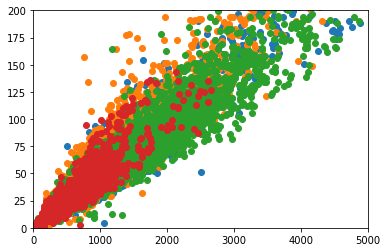

In [78]:
#plot word count vs sentence length
#total_df.groupby('publication').plot(x='word_count', y='sentence_count', style='o')
plt.scatter(total_df.loc[total_df['publication'] == 'New York Times','word_count'], total_df.loc[total_df['publication'] == 'New York Times','sentence_count'])
plt.scatter(total_df.loc[total_df['publication'] == 'Washington Post','word_count'], total_df.loc[total_df['publication'] == 'Washington Post','sentence_count'])
plt.scatter(total_df.loc[total_df['publication'] == 'Vox','word_count'], total_df.loc[total_df['publication'] == 'Vox','sentence_count'])
plt.scatter(total_df.loc[total_df['publication'] == 'Fox News','word_count'], total_df.loc[total_df['publication'] == 'Fox News','sentence_count'])

plt.xlim((0,5000))

plt.ylim((0,200))
plt.show()

In [48]:
#total_df['unique_word_count'] = 0

In [53]:
def unique_word_count(pub_name):
    col_name = 'unique_word_count'
    total_df.loc[total_df['publication'] == pub_name, col_name] = total_df.loc[total_df['publication'] == pub_name]['content'].apply(lambda row: len(set(row.lower().split())))
    #nyt_group['word_count'] = nyt_group['content'].str.split().str.len()
    #print(nyt_group.head(10))
    print(list(total_df))
    #print(total_df.loc[total_df['publication'] == pub_name])

#nyt_group['sentence_count'] = nyt_group['content']
#print(nyt_group.sentence_count)

In [79]:
#unique_word_count('New York Times')
#unique_word_count('Vox')
#unique_word_count('Washington Post')
unique_word_count('Fox News')
print(total_df.groupby('publication')['unique_word_count'].describe())

['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content', 'sentence_count', 'word_count', 'unique_word_count']
                       count        mean         std   min    25%    50%  \
publication                                                                
Atlantic              7179.0    0.000000    0.000000   0.0    0.0    0.0   
Breitbart            23781.0    0.000000    0.000000   0.0    0.0    0.0   
Business Insider      6757.0    0.000000    0.000000   0.0    0.0    0.0   
Buzzfeed News         4854.0    0.000000    0.000000   0.0    0.0    0.0   
CNN                  11488.0    0.000000    0.000000   0.0    0.0    0.0   
Fox News              4354.0  291.107487  150.401531   1.0  181.0  273.0   
Guardian              8681.0    0.000000    0.000000   0.0    0.0    0.0   
NPR                  11992.0    0.000000    0.000000   0.0    0.0    0.0   
National Review       6203.0    0.000000    0.000000   0.0    0.0    0.0   
New York Post

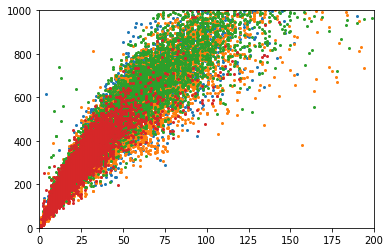

In [80]:
#total_df.groupby('publication').plot(x='word_count', y='sentence_count', style='o')
plt.scatter(total_df.loc[total_df['publication'] == 'New York Times','sentence_count'], total_df.loc[total_df['publication'] == 'New York Times','unique_word_count'], s=4)
plt.scatter(total_df.loc[total_df['publication'] == 'Washington Post','sentence_count'], total_df.loc[total_df['publication'] == 'Washington Post','unique_word_count'], s=4)
plt.scatter(total_df.loc[total_df['publication'] == 'Vox','sentence_count'], total_df.loc[total_df['publication'] == 'Vox','unique_word_count'], s=4)
plt.scatter(total_df.loc[total_df['publication'] == 'Fox News','sentence_count'], total_df.loc[total_df['publication'] == 'Fox News','unique_word_count'], s=4)

plt.xlim((0,200))

plt.ylim((0,1000))
plt.show()

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


publication
Atlantic               AxesSubplot(0.125,0.125;0.775x0.755)
Breitbart              AxesSubplot(0.125,0.125;0.775x0.755)
Business Insider       AxesSubplot(0.125,0.125;0.775x0.755)
Buzzfeed News          AxesSubplot(0.125,0.125;0.775x0.755)
CNN                    AxesSubplot(0.125,0.125;0.775x0.755)
Fox News               AxesSubplot(0.125,0.125;0.775x0.755)
Guardian               AxesSubplot(0.125,0.125;0.775x0.755)
NPR                    AxesSubplot(0.125,0.125;0.775x0.755)
National Review        AxesSubplot(0.125,0.125;0.775x0.755)
New York Post          AxesSubplot(0.125,0.125;0.775x0.755)
New York Times         AxesSubplot(0.125,0.125;0.775x0.755)
Reuters                AxesSubplot(0.125,0.125;0.775x0.755)
Talking Points Memo    AxesSubplot(0.125,0.125;0.775x0.755)
Vox                    AxesSubplot(0.125,0.125;0.775x0.755)
Washington Post        AxesSubplot(0.125,0.125;0.775x0.755)
Name: word_count, dtype: object

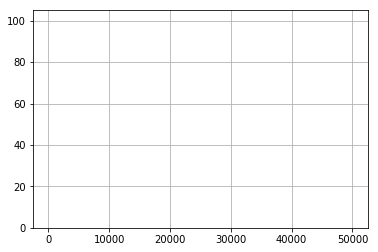

In [30]:
#sub_df_max_wordcount = sub_df
total_df.groupby('publication')['word_count'].hist(bins = 100, alpha = 0.5, normed = True)